In [1]:
import sys
sys.path.append('/uio/kant/geo-metos-u7/franzihe/Documents/Thesis/Python/')
sys.path.append('/uio/kant/geo-metos-u7/franzihe/Documents/Thesis/Python/weather_mast/')
sys.path.append('/uio/kant/geo-metos-u7/franzihe/Documents/Thesis/Python/Retrieval/')
sys.path.append('/uio/kant/geo-metos-u7/franzihe/Documents/Thesis/Python/Retrieval_MEPS/')

import netCDF4
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from scipy import stats, integrate
import seaborn
import createFolder as cF


import plt_ce_image as im
import plot_sfc_spaghetti_ret as spagh
import calc_date as cd
np.warnings.filterwarnings('ignore')

In [2]:
year = '2016'
month = '12'
t = np.arange(20,28)
tid = '00'
station = 'Haukeliseter'

In [3]:
savefig = 0
figdir = '../../Figures/Retrieval_MEPS/'
if savefig == 1:
    cF.createFolder('%s/' %figdir)
form = 'png'

In [4]:
################################################################
### MEPS
level = 'sfc'
nc_dir_sfc = '../../../Thesis/Data/MEPS/%s/%s_%s' %(station, level, tid)

level = 'ml'
nc_dir_ml = '../../../Thesis/Data/MEPS/%s/%s_%s' %(station, level, tid)

nc_dir_10m = '../../Data/Weathermast_MEPS_Retrieval/%s/' %(station)

# air temperature
var_name_air_temp = 'air_temperature_ml'
air_temp_dir = '%s/%s' %(nc_dir_ml,var_name_air_temp)

# snow fall amount
var_name_snow = 'snowfall_amount_ml'
snow_dir = '%s/%s' %(nc_dir_ml,var_name_snow)

# graupel fall amount
var_name_graupel = 'graupelfall_amount_ml'
graupel_dir = '%s/%s' %(nc_dir_ml,var_name_graupel)

# atmosphere_cloud_ice_content_ml
var_name_cl_ice = 'atmosphere_cloud_ice_content_ml'
cl_ice_dir = '%s/%s' %(nc_dir_ml,var_name_cl_ice)

# wind direction_10m
#var_name_wind_dir = 
wind_10m_dir = '%s' %(nc_dir_10m)

################################################################
### MRR

MRR_dir = '../../../Thesis/Data/MRR/processed_MRR'

################################################################
### Retrieval 
nc_dir_retrieval = '../../../Thesis/Data/Retrieved_SWC'

################################################################
### Eklima
nc_dir_eklima = '../../Data/Eklima/%s/' %(station)

In [5]:
Rd = 287.    # gas constant for dry air [J kg^-1 K^-1]

In [6]:
## MRR ######
fnMRR      = dict()
time_MRR   = dict()
height_MRR = dict()
Ze         = dict()

In [7]:
## RETRIEVAL ######
fnRet      = dict()
retrieved_snowfall_amount = dict()
SWC        = dict()
SWP_ret    = dict() 
SWC_inst   = dict()
SWP_inst   = dict()

In [8]:
## MEPS ######
ice_amount_ml = dict()
time_MEPS     = dict()
height_MEPS   = dict()
SWC_MEPS      = dict()
SWP_MEPS     = dict()
meps_wind_speed = dict()
meps_wind_dir = dict()
meps_westerly_idx = dict()
meps_easterly_idx = dict()

In [9]:
## EKLIMA ######
fn_eklima = dict()
eklima_wind_dir_10m   = dict()
eklima_wind_speed_10m = dict()

In [10]:
### layer for average snow water content within 200 m
nlay= 15
bot = []
top = []
for k in range(0, nlay):
    bot.append(100.+ k*200)
    top.append(bot[k]+200)



In [11]:
for day in t:
    Date = year+month+str(day)
    ## MRR ######  
    fnMRR[Date] = pd.read_csv('%s/VMRR_data.MRR_HKL_%s_maahn_r01.nc.dat' %(MRR_dir,Date), header=1,delim_whitespace=True)

    time_MRR[Date]   = fnMRR[Date]['height'][0:fnMRR[Date]['height'].shape[0]:15]
    height_MRR[Date] = fnMRR[Date]['height'][1:15]
    Ze[Date]         = fnMRR[Date]['ZE'][~np.isnan(fnMRR[Date]['ZE'])]
    Ze[Date]         = np.reshape(np.array(Ze[Date]), 
                                  ( height_MRR[Date].shape[0], time_MRR[Date].shape[0],), 
                                  order='F')

    ## RETRIEVAL ######
    fnRet[Date] = netCDF4.Dataset('%s/out_swc_b6_%s.nc' %(nc_dir_retrieval, Date))
    retrieved_snowfall_amount[Date] = fnRet[Date].variables['retrieved_snowfall_amount'][:]
    SWC[Date] = fnRet[Date].variables['SWC'][:]
######
    ## EKLIMA #####
    fn_eklima[Date] = netCDF4.Dataset(nc_dir_eklima+'precip_wind_temp_%s.nc' %(Date),'r')
    eklima_wind_dir_10m[Date]   = (fn_eklima[Date].variables['DD'][:])
    eklima_wind_speed_10m[Date] = (fn_eklima[Date].variables['FF'][:])

    ### for plotting, only values larger than 0.01
#    a,b = np.where(retrieved_snowfall_amount[Date][:,:] < 0.01)
 #   SWC[Date][a[:], b[:]]      = np.nan
  #  Ze[Date][a[:], b[:]]       = np.nan
    
#    # for instantenous values
 #   a,b = np.where(retrieved_snowfall_amount[Date][:,::60] < 0.01)
  #  SWC_inst[Date][a[:], b[:]] = np.nan
    
######    
    ## MEPS ######
    ens_memb = 0

    air_temp_file = '%s/%s%s%s_%s_%s.nc' %(air_temp_dir,year,month,day,tid,ens_memb)
    snow_file = '%s/%s%s%s_%s_%s.nc' %(snow_dir,year,month,day,tid,ens_memb)
    graupel_file = '%s/%s%s%s_%s_%s.nc' %(graupel_dir,year,month,day,tid,ens_memb)
    cl_ice_file  = '%s/%s%s%s_%s_%s.nc' %(cl_ice_dir,year,month,day,tid,ens_memb)
    wind_10m_file = '%s/weathermast_meps_retrieval_%s%s%s.nc' %(wind_10m_dir,year,month,day)

    fn_air_temp  = netCDF4.Dataset(air_temp_file,'r')
    fn_snow      = netCDF4.Dataset(snow_file,'r')
    fn_graupel   = netCDF4.Dataset(graupel_file,'r') 
    fn_cl_ice    = netCDF4.Dataset(cl_ice_file,'r')
    fn_wind_10m  = netCDF4.Dataset(wind_10m_file,'r')

    # Read in the pressure, and the air temperature to calculate ice amount from [kg/kg] to [kg/m^3]
    air_temp_ml = fn_air_temp.variables[var_name_air_temp][:]
    pressure_ml = fn_snow.variables['pressure_ml'][:]

    # Read in the variable name which should be plotted  
    snow_amount_ml    = fn_snow.variables[var_name_snow][:]
    graupel_amount_ml = fn_graupel.variables[var_name_graupel][:]
    cl_ice_ml         = fn_cl_ice.variables[var_name_cl_ice][:]
    meps_wind_speed[Date]   = fn_wind_10m.variables['meps_wind_speed'][:]
    meps_wind_dir[Date]     = fn_wind_10m.variables['meps_wind_direction'][:]
    meps_westerly_idx[Date] = fn_wind_10m.variables['meps_idx_westerly'][:]
    meps_easterly_idx[Date] = fn_wind_10m.variables['meps_idx_easterly'][:]


    # create an array with time of the shape of the variable
    lead_time   = np.arange(0,snow_amount_ml.shape[0])
    model_level = np.arange(0,snow_amount_ml.shape[1])
    td,Y        = np.meshgrid(lead_time,model_level)

    # get ice amount (snow+graupel)
    ice_amount_ml[Date]    = snow_amount_ml + graupel_amount_ml + cl_ice_ml


    # layer thickness to calculate height
    thickness_ml      = fn_snow.variables['layer_thickness']
    thickness = thickness_ml
    h_above = []
    h_above.append(np.zeros(thickness[:,:].shape[0]))
    th_arr = np.nansum([np.asarray(h_above)[:,0], thickness[:,0]], axis = 0)
    h_above.append(th_arr)
    for i in range(2,thickness[:,:].shape[1]):
        th_arr = np.nansum([h_above[i-1], thickness[:,i-1]], axis = 0)
        h_above.append(th_arr)
    height_ml = np.transpose(h_above) 

    ####
    # calculate density at each level
    density_ml = pressure_ml/(Rd*air_temp_ml)

    # convert from [kg/kg] to [kg/m^3]
    ice_amount_ml[Date] = (ice_amount_ml[Date]*density_ml)

    # convert the snow amount from [kg/m^2] into [g/m^2] by multiply with 1000
    ice_amount_ml[Date] = (ice_amount_ml[Date]*1000.)

#    # calculate mean of snowfall amount in each layer, every 200m
 #   SWC_ml = []
  #  h_mid = []
   # for k in range(0, nlay):
    #    tidx,hidx = np.where(np.logical_and(height_ml[:,:] >= bot[k], height_ml[:,:] < top[k]))
#    # average in layer
 #       SWC_ml.append(np.nanmean(ice_amount_ml[Date][:,hidx[:]], axis = 1))
  #      h_mid.append((bot[k]+top[k])/2)
   # avg_SWC_ml = SWC_ml      

    #time_MEPS[Date]     = td
    #height_MEPS[Date]   = height_ml   

    time_MEPS[Date] = np.empty(shape=(td.shape[1], height_MRR[Date].shape[0]))
    height_MEPS[Date] = np.empty(shape=(height_ml.shape[0], height_MRR[Date].shape[0]))
    SWC_MEPS[Date] = np.empty(shape=(ice_amount_ml[Date].shape[0], height_MRR[Date].shape[0]))
    for i in range(height_ml.shape[0]):
        for k in range(height_MRR[Date].shape[0]):
            idx1 = (np.abs(height_ml[i,:] - np.array(height_MRR[Date])[k]).argmin())
        
            height_MEPS[Date][i,k] = height_ml[i,idx1]
            time_MEPS[Date][i,k]   = td[idx1,i]
            SWC_MEPS[Date][i,k]    = ice_amount_ml[Date][i,idx1]
            
    SWP_MEPS[Date] = integrate.simps(SWC_MEPS[Date][:,:], height_MEPS[Date][:,:], axis = 1)
    
    
    ######################################
    fnRet[Date].close(), fn_air_temp.close(), fn_snow.close(), fn_graupel.close(), fn_cl_ice.close(), fn_eklima[Date].close()

In [64]:
#SWC_48[Date] = np.concatenate((SWC[Date][:,:], SWC[str(int(Date)+1)][:,:]),axis=1)
retrieved_snowfall_amount_48 = dict()
SWC_48                       = dict()
SWP_48_ret                   = dict()
Ze_48                        = dict()
eklima_wind_dir_48           = dict()
eklima_wind_speed_48         = dict()

eklima_westerly_idx          = dict()
eklima_easterly_idx          = dict()
SWC_24_total = dict()
SWC_24_east  = dict()
SWC_24_west  = dict()
SWP_24_total = dict()
SWP_24_east  = dict()
SWP_24_west  = dict()

SWC_24_total_meps = dict()
SWC_24_east_meps  = dict()
SWC_24_west_meps  = dict()
SWP_24_total_meps = dict()
SWP_24_east_meps  = dict()
SWP_24_west_meps  = dict()

for day in t:
    Date = year+month+str(day)
    if day == 26:
        retrieved_snowfall_amount_48[Date] = np.column_stack([retrieved_snowfall_amount[Date], 
                                                             retrieved_snowfall_amount[str(int(Date)+1)][:,:]])
        SWC_48[Date] = np.column_stack([SWC[Date], SWC[str(int(Date)+1)][:,:]])
        Ze_48[Date] = np.column_stack([Ze[Date], Ze[str(int(Date)+1)][:,:]])
        
        SWC_inst[Date] = np.column_stack([SWC[Date], SWC[str(int(Date)+1)][:,:]])
        SWC_inst[Date] = SWC_inst[Date][:,::60]
        
        eklima_wind_dir_48[Date] = np.column_stack([eklima_wind_dir_10m[Date][:],
                                                    eklima_wind_dir_10m[str(int(Date)+1)][:]])
        eklima_wind_dir_48[Date] = np.reshape(eklima_wind_dir_48[Date], 
                                             eklima_wind_dir_48[Date].shape[0]*eklima_wind_dir_48[Date].shape[1])[:49]
        
        eklima_wind_speed_48[Date] = np.column_stack([eklima_wind_speed_10m[Date][:],
                                                      eklima_wind_speed_10m[str(int(Date)+1)][:]])
        eklima_wind_speed_48[Date] = np.reshape(eklima_wind_speed_48[Date],
                                                eklima_wind_speed_48[Date].shape[0]*eklima_wind_speed_48[Date].shape[1])[:49]

    elif day == 27:
        retrieved_snowfall_amount_48[Date] = retrieved_snowfall_amount[Date][:]
        SWC_48[Date] = SWC[Date][:]
        Ze_48[Date] = Ze[Date][:]
        
        SWC_inst[Date] = SWC[Date][:]
        SWC_inst[Date] = SWC_inst[Date][:,::60]
        
        eklima_wind_dir_48[Date] = eklima_wind_dir_10m[Date][:]
        eklima_wind_speed_48[Date] = eklima_wind_speed_10m[Date][:]
        
    else:
        retrieved_snowfall_amount_48[Date] = np.column_stack([retrieved_snowfall_amount[Date],
                                                             retrieved_snowfall_amount[str(int(Date)+1)][:,:],
                                                             retrieved_snowfall_amount[str(int(Date)+2)][:,0]])
        SWC_48[Date] = np.column_stack([SWC[Date], SWC[str(int(Date)+1)][:,:], SWC[str(int(Date)+2)][:,0] ])
        Ze_48[Date]  = np.column_stack([Ze[Date], Ze[str(int(Date)+1)][:,:], Ze[str(int(Date)+2)][:,0] ])

        SWP_48_ret[Date] = integrate.simps(SWC_48[Date][:,:], height_MRR[Date], axis = 0)
        
        SWC_inst[Date] = np.column_stack([SWC[Date], SWC[str(int(Date)+1)][:,:], SWC[str(int(Date)+2)][:,0] ])
        SWC_inst[Date] = SWC_inst[Date][:,::60]
        
        eklima_wind_dir_48[Date] = np.column_stack([eklima_wind_dir_10m[Date][:],
                                                    eklima_wind_dir_10m[str(int(Date)+1)][:],
                                                    eklima_wind_dir_10m[str(int(Date)+2)][:]])
        eklima_wind_dir_48[Date] = np.reshape(eklima_wind_dir_48[Date], 
                                             eklima_wind_dir_48[Date].shape[0]*eklima_wind_dir_48[Date].shape[1])[:49]
 
        eklima_wind_speed_48[Date] = np.column_stack([eklima_wind_speed_10m[Date][:],
                                                      eklima_wind_speed_10m[str(int(Date)+1)][:],
                                                      eklima_wind_speed_10m[str(int(Date)+2)][:]])
        eklima_wind_speed_48[Date] = np.reshape(eklima_wind_speed_48[Date],
                                                eklima_wind_speed_48[Date].shape[0]*eklima_wind_speed_48[Date].shape[1])[:49]


    ### hourly SWC 
#    SWC_inst[Date] = SWC_48[Date][:,::60]
    

    ### hourly SWP
    SWP_inst[Date] = integrate.simps(SWC_inst[Date][:,:], height_MRR[Date], axis = 0)
    
    
    ### for plotting, only values larger than 0.01
    a,b = np.where(retrieved_snowfall_amount_48[Date][:,:] < 0.01)
    SWC_48[Date][a[:], b[:]]      = np.nan
  #  Ze_48[Date][a[:], b[:]]       = np.nan
    
#    # for instantenous values
 #   a,b = np.where(retrieved_snowfall_amount[Date][:,::60] < 0.01)
  #  SWC_inst[Date][a[:], b[:]] = np.nan

##### WIND for Retrieval #####
### Find wind regimes and associated SWC, SWP
    IDX = np.arange(eklima_wind_dir_48[Date][:25].shape[0])

## find all eklima_westerly regimes (202.5 - 22.5 deg) 
    eklima_westerly_idx[Date]  = IDX[np.logical_or(np.logical_and((eklima_wind_dir_48[Date][:25,] >= 202.5),
                                                                  (eklima_wind_dir_48[Date][:25,] <= 360)),
                                                   (eklima_wind_dir_48[Date][:25,] <22.5))]
## find all eklima_easterly regimes (22.5 - 202.5 deg)
    eklima_easterly_idx[Date]  = IDX[np.logical_and((eklima_wind_dir_48[Date][:25,] >= 22.5),
                                                    (eklima_wind_dir_48[Date][:25,] < 202.5))]


    if len(eklima_westerly_idx[Date]) == 0:    # only easterlies
                eklima_easterly_idx[Date]  = eklima_easterly_idx[Date].astype(int)
    elif len(eklima_easterly_idx[Date]) == 0:  # only westerlies
                eklima_westerly_idx[Date]  = eklima_westerly_idx[Date].astype(int)
    else:    # both easterlies and westerlies
                eklima_easterly_idx[Date]  = eklima_easterly_idx[Date].astype(int)
                eklima_westerly_idx[Date]  = eklima_westerly_idx[Date].astype(int)

## assign mean values to days
    if len(eklima_easterly_idx[Date]) == 0 and len(eklima_westerly_idx[Date]) == 0:
        SWC_24_total[Date] = np.empty(shape=(SWC_inst[Date].shape[0],))
        SWC_24_total[Date][:] = np.nan
        SWC_24_east[Date] = np.empty(shape=(SWC_inst[Date].shape[0],))
        SWC_24_east[Date][:] = np.nan
        SWC_24_west[Date] = np.empty(shape=(SWC_inst[Date].shape[0],))
        SWC_24_west[Date][:] = np.nan
        
        SWP_24_total[Date] = np.empty(shape=(SWP_inst[Date].shape[0],))
        SWP_24_total[Date][:] = np.nan
        SWP_24_east[Date] = np.empty(shape=(SWP_inst[Date].shape[0],))
        SWP_24_east[Date][:] = np.nan
        SWP_24_west[Date] = np.empty(shape=(SWP_inst[Date].shape[0],))
        SWP_24_west[Date][:] = np.nan
    elif len(eklima_easterly_idx[Date]) == 0:
        SWC_24_total[Date] = np.nanmean(SWC_inst[Date][:, eklima_westerly_idx[Date]], axis=1)
        SWC_24_east[Date] = np.empty(shape=(SWC_inst[Date].shape[0],))
        SWC_24_east[Date][:] = np.nan
        SWC_24_west[Date] = np.nanmean(SWC_inst[Date][:, eklima_westerly_idx[Date]], axis=1)
        
        SWP_24_total[Date] = np.nansum(SWP_inst[Date][eklima_westerly_idx[Date]], axis=0)
        SWP_24_east[Date] = np.empty(shape=(SWP_inst[Date].shape[0],))
        SWP_24_east[Date][:] = np.nan
        SWP_24_west[Date] = np.nansum(SWP_inst[Date][eklima_westerly_idx[Date]], axis=0)
        
    elif len(eklima_westerly_idx[Date]) == 0:
        SWC_24_total[Date] = np.nanmean(SWC_inst[Date][:, eklima_easterly_idx[Date]], axis=1)
        SWC_24_east[Date] = np.nanmean(SWC_inst[Date][:, eklima_easterly_idx[Date]], axis=1)
        SWC_24_west[Date] = np.empty(shape=(SWC_inst[Date].shape[0],))
        SWC_24_west[Date][:] = np.nan
        
        SWP_24_total[Date] = np.nanmean(SWP_inst[Date][eklima_easterly_idx[Date]], axis=0)
        SWP_24_east[Date] = np.nanmean(SWP_inst[Date][eklima_easterly_idx[Date]], axis=0)
        SWP_24_west[Date] = np.empty(shape=(SWP_inst[Date].shape[0],))
        SWP_24_west[Date][:] = np.nan
    else:
        SWC_24_total[Date] = np.nanmean(SWC_inst[Date][:, eklima_easterly_idx[Date]], axis=1) + \
                             np.nanmean(SWC_inst[Date][:, eklima_westerly_idx[Date]], axis=1)
        SWC_24_east[Date] = np.nanmean(SWC_inst[Date][:, eklima_easterly_idx[Date]], axis=1)
        SWC_24_west[Date] = np.nanmean(SWC_inst[Date][:, eklima_westerly_idx[Date]], axis=1)
        
        SWP_24_total[Date] = np.nanmean(SWP_inst[Date][eklima_easterly_idx[Date]], axis=0) + \
                             np.nanmean(SWP_inst[Date][eklima_westerly_idx[Date]], axis=0)
        SWP_24_east[Date] = np.nanmean(SWP_inst[Date][eklima_easterly_idx[Date]], axis=0)
        SWP_24_west[Date] = np.nanmean(SWP_inst[Date][eklima_westerly_idx[Date]], axis=0)
        
        
##### WIND for MEPS #####
### Find wind regimes and associated SWC, SWP

## assign mean values to days
    if len(meps_easterly_idx[Date]) == 0 and len(meps_westerly_idx[Date]) == 0:
        SWC_24_total_meps[Date] = np.empty(shape=(SWC_MEPS[Date].shape[1],))
        SWC_24_total_meps[Date][:] = np.nan
        SWC_24_east_meps[Date] = np.empty(shape=(SWC_MEPS[Date].shape[1],))
        SWC_24_east_meps[Date][:] = np.nan
        SWC_24_west_meps[Date] = np.empty(shape=(SWC_MEPS[Date].shape[1],))
        SWC_24_west_meps[Date][:] = np.nan
        
        SWP_24_total_meps[Date] = np.empty(shape=(SWP_MEPS[Date].shape[0],))
        SWP_24_total_meps[Date][:] = np.nan
        SWP_24_east_meps[Date] = np.empty(shape=(SWP_MEPS[Date].shape[0],))
        SWP_24_east_meps[Date][:] = np.nan
        SWP_24_west_meps[Date] = np.empty(shape=(SWP_MEPS[Date].shape[0],))
        SWP_24_west_meps[Date][:] = np.nan
    elif len(meps_easterly_idx[Date][~np.isnan(meps_easterly_idx[Date])]) == 0:
        SWC_24_total_meps[Date] = np.nanmean(SWC_MEPS[Date][meps_westerly_idx[Date][~np.isnan(meps_westerly_idx[Date][:,0]),0].astype(int),:], axis=0)
        SWC_24_east_meps[Date] = np.empty(shape=(SWC_MEPS[Date].shape[1],))
        SWC_24_east_meps[Date][:] = np.nan
        SWC_24_west_meps[Date] = np.nanmean(SWC_MEPS[Date][meps_westerly_idx[Date][~np.isnan(meps_westerly_idx[Date][:,0]),0].astype(int),:], axis=0)
        
        SWP_24_total_meps[Date] = np.nansum(SWP_MEPS[Date][meps_westerly_idx[Date][~np.isnan(meps_westerly_idx[Date][:,0]),0].astype(int)],axis=0)
        SWP_24_east_meps[Date] = np.empty(shape=(SWP_MEPS[Date].shape[0],))
        SWP_24_east_meps[Date][:] = np.nan
        SWP_24_west_meps[Date] = np.nansum(SWP_MEPS[Date][meps_westerly_idx[Date][~np.isnan(meps_westerly_idx[Date][:,0]),0].astype(int)],axis=0)
        
    elif len(meps_westerly_idx[Date][~np.isnan(meps_westerly_idx[Date])]) == 0:
        SWC_24_total_meps[Date] = np.nanmean(SWC_MEPS[Date][meps_easterly_idx[Date][~np.isnan(meps_easterly_idx[Date][:,0]),0].astype(int),:], axis=0)
        SWC_24_east_meps[Date] = np.nanmean(SWC_MEPS[Date][meps_easterly_idx[Date][~np.isnan(meps_easterly_idx[Date][:,0]),0].astype(int),:], axis=0)
        SWC_24_west_meps[Date] = np.empty(shape=(SWC_MEPS[Date].shape[1],))
        SWC_24_west_meps[Date][:] = np.nan
        
        SWP_24_total_meps[Date] = np.nansum(SWP_MEPS[Date][meps_easterly_idx[Date][~np.isnan(meps_easterly_idx[Date][:,0]),0].astype(int)],axis=0)
        SWP_24_east_meps[Date] = np.nansum(SWP_MEPS[Date][meps_easterly_idx[Date][~np.isnan(meps_easterly_idx[Date][:,0]),0].astype(int)],axis=0)
        SWP_24_west_meps[Date] = np.empty(shape=(SWP_MEPS[Date].shape[0],))
        SWP_24_west_meps[Date][:] = np.nan
    else:
        SWC_24_total_meps[Date] = np.nanmean(SWC_MEPS[Date][meps_easterly_idx[Date][~np.isnan(meps_easterly_idx[Date][:,0]),0].astype(int),:], axis=0) + \
                             np.nanmean(SWC_MEPS[Date][meps_easterly_idx[Date][~np.isnan(meps_easterly_idx[Date][:,0]),0].astype(int),:], axis=0)
        SWC_24_east_meps[Date] = np.nanmean(SWC_MEPS[Date][meps_easterly_idx[Date][~np.isnan(meps_easterly_idx[Date][:,0]),0].astype(int),:], axis=0)
        SWC_24_west_meps[Date] = np.nanmean(SWC_MEPS[Date][meps_westerly_idx[Date][~np.isnan(meps_westerly_idx[Date][:,0]),0].astype(int),:], axis=0)
        
        SWP_24_total_meps[Date] = np.nansum(SWP_MEPS[Date][meps_easterly_idx[Date][~np.isnan(meps_easterly_idx[Date][:,0]),0].astype(int)],axis=0) + \
                             np.nansum(SWP_MEPS[Date][meps_westerly_idx[Date][~np.isnan(meps_westerly_idx[Date][:,0]),0].astype(int)],axis=0)
        SWP_24_east_meps[Date] = np.nansum(SWP_MEPS[Date][meps_easterly_idx[Date][~np.isnan(meps_easterly_idx[Date][:,0]),0].astype(int)],axis=0)
        SWP_24_west_meps[Date] = np.nansum(SWP_MEPS[Date][meps_westerly_idx[Date][~np.isnan(meps_westerly_idx[Date][:,0]),0].astype(int)],axis=0)

In [13]:
def plt_SWC_retrieval(time_MRR,height_MRR,mergedZe,mergedSWC,SWC_inst,SWP,
                     time_MEPS,height_MEPS,SWC_MEPS,SWP_MEPS):
    
    mpl.style.use('classic')
    plt.rcParams.update({'font.size': 10})
    seaborn.set_context("paper")
    
#    fig = plt.figure(figsize=(30.,10.))
    fig = plt.figure()
    fig.set_figheight(8*2)
    fig.set_figwidth(12*5/3)
    fig.subplots_adjust(hspace=0.08, wspace=0.)
### SWC minutely retrieval #####
    gs = gridspec.GridSpec(5,3)
#    gs = fig.add_gridspec(5, 3)
## 1st subplot --- REFLECTIVITY
    ax0 = fig.add_subplot(gs[0,:-1])
    
    levels = np.arange(-10,30.1,0.1)
#    if day == '26':
 #       im0= im.plt_ce_image2(ax0,np.arange(0,2*time_MRR.max()-60,60), height_MRR, np.transpose(mergedZe),
  #                        levels,
   #         v_min=0.0, v_max=30., xmax=2*time_MRR.max(), ymax=height_MRR.max(), 
    #        xticks=np.arange(0,60*60*49,3*60*60), yticks=im.yticks1,
     #       xlabel=xdays)
    #else:
#       im0= im.plt_ce_image2(ax0,np.arange(0,2*time_MRR.max()+60,60), height_MRR, np.transpose(mergedZe),
 #                         levels,
  #          v_min=0.0, v_max=30., xmax=2*time_MRR.max(), ymax=height_MRR.max(), 
   #         xticks=np.arange(0,60*60*49,3*60*60), yticks=im.yticks1,
    #        xlabel=xdays)
    im0= im.plt_ce_image2(ax0,np.arange(0,mergedZe.shape[1]), height_MRR, mergedZe,
                          levels,
            v_min=0.0, v_max=30., xmax=mergedZe.shape[1]-60, ymax=height_MRR.max(), 
            xticks=np.arange(0,mergedZe.shape[1],60), yticks=im.yticks1,
            xlabel=xdays)
    ax0.xaxis.grid()      
    # Vertical line to show end of day
    ax0.axvline(0,color = spagh.vert_col, linewidth = 3)
    ax0.axvline(24*60,color = spagh.vert_col, linewidth = 3)
    ax0.axvline(48*60,color = spagh.vert_col, linewidth = 3)

    ax0.text(0.02,0.95, '%s, %s %s %s' %(calday, day, calmon, year),
            verticalalignment ='top', horizontalalignment='left',
             transform = ax0.transAxes,
             color = im.date_blue, fontsize = im.fontsize+2,
             bbox={'facecolor':'white','alpha':1.,'pad':5})
    

#    ax00 = plt.subplot(gs[0,-1])
    ax00 = fig.add_subplot(gs[0,-1])
#    cbaxes = fig.add_axes([0.685, .625, 0.017,0.33])  # [left, bottom, width, height] 
    cbaxes = fig.add_axes([0.655, .750, 0.017,0.155])  # [left, bottom, width, height] 
    im.add_colorbar2(fig,ax00,im0, cbaxes, levels[::50], 'Ze [dBZ]')

################
## 2nd subplot --- SNOW WATER CONTENT RETRIEVAL
    ax1 = fig.add_subplot(gs[1,:-1])
    
    levels = np.arange(0,1.51,0.01) 
#    if day == '26':
 #       im1 = im.plt_ce_image(fig,ax1, np.arange(0,2*time_MRR.max()-60,60),height_MRR, np.transpose(mergedSWC), 
  #                       levels,
   #         v_min=0., v_max=1.5, xmax=2*time_MRR.max(), ymax=height_MRR.max(),
    #        xticks=np.arange(0,60*60*49,3*60*60), yticks=im.yticks1,cb_ticks =[],
     #       xlabel=xdays,var_label = [], cb=0)
    #else:
#        im1 = im.plt_ce_image(fig,ax1, np.arange(0,2*time_MRR.max()+60,60),height_MRR, np.transpose(mergedSWC), 
 #                        levels,
  #          v_min=0., v_max=1.5, xmax=2*time_MRR.max(), ymax=height_MRR.max(),
   #         xticks=np.arange(0,60*60*49,3*60*60), yticks=im.yticks1, cb_ticks =[],
    #        xlabel=xdays,var_label = [], cb=0)
    im1 = im.plt_ce_image2(ax1, np.arange(0,mergedSWC.shape[1]),height_MRR, mergedSWC, 
                         levels,
            v_min=0., v_max=1.5, xmax=mergedSWC.shape[1]-60, ymax=height_MRR.max(),
            xticks=np.arange(0,mergedSWC.shape[1],60), yticks=im.yticks1,
            xlabel=xdays)
      
        
        
        
    ax1.xaxis.grid()
    # Vertical line to show end of day
    ax1.axvline(0,color = spagh.vert_col, linewidth = 3)
    ax1.axvline(24*60,color = spagh.vert_col, linewidth = 3)
    ax1.axvline(48*60,color = spagh.vert_col, linewidth = 3)
    ax1.text(0.02,0.95, 'SWC$_{Retrieval}$' ,
            verticalalignment ='top', horizontalalignment='left',
             transform = ax1.transAxes,
             color = 'k', fontsize = im.fontsize+2,
             bbox={'facecolor':'white','alpha':1.,'pad':5})
    
#    ax01 = plt.subplot(gs[1,-1])
 #   cbaxes = fig.add_axes([0.685, .225, 0.017,0.33])  # [left, bottom, width, height] 
  #  im.add_colorbar2(fig,ax01,im1, cbaxes, levels[::30], 'SWC [g m$^{-3}$]')

################
## 3rd subplot --- SNOW WATER CONTENT RETRIEVAL INSTANTANEOUS
    ax2 =fig.add_subplot(gs[2,:-1])
    
#    im2 = im.plt_ce_image(fig, ax2, np.arange(0,time_MRR.max()+60,60*60), height_MRR, SWC_inst,
 #                  levels,
  #                 v_min=0., v_max=1.5, xmax=time_MRR.max(), ymax=height_MRR.max(),
   #                xticks=np.arange(0,60*60*25,3*60*60), yticks=im.yticks1, cb_ticks =[],
    #               xlabel=xdays,var_label = [], cb=0)
    im2 = im.plt_ce_image2(ax2, np.arange(0,SWC_inst.shape[1]), height_MRR, SWC_inst,
                   levels,
                   v_min=0., v_max=1.5, xmax=SWC_inst.shape[1]-1, ymax=height_MRR.max(),
                   xticks=np.arange(0,SWC_inst.shape[1]), yticks=im.yticks1, 
                   xlabel=xdays)
    
    ax2.xaxis.grid()
    # Vertical line to show end of day
    ax2.axvline(0,color = spagh.vert_col, linewidth = 3)
    ax2.axvline(24,color = spagh.vert_col, linewidth = 3)
    ax2.axvline(48,color = spagh.vert_col, linewidth = 3)
    
    ax2.text(0.02,0.95, 'SWC$_{Retrieval\,\,instantenous}$' ,
            verticalalignment ='top', horizontalalignment='left',
             transform = ax2.transAxes,
             color = 'k', fontsize = im.fontsize+2,
             bbox={'facecolor':'white','alpha':1.,'pad':5})
    

################
## 4th subplot --- SNOW WATER CONTENT ML 
    ax3 = fig.add_subplot(gs[3,:-1])
    
#    im3 = im.plt_ce_image(fig, ax3, np.transpose(time_MEPS), height_MEPS, SWC_MEPS, levels,
 #                        v_min=0., v_max=1.5, xmax=SWC_MEPS.shape[0]-1, ymax= 3000.,
  #                       xticks=np.arange(0,SWC_MEPS.shape[0]), yticks=im.yticks1, cb_ticks = [],
   #                      xlabel=xdays, var_label=[], cb=0)
    im3 = im.plt_ce_image2(ax3, time_MEPS, height_MEPS, SWC_MEPS, levels,
                         v_min=0., v_max=1.5, xmax=SWC_MEPS.shape[0]-1, ymax= 3000.,
                         xticks=np.arange(0,SWC_MEPS.shape[0]), yticks=im.yticks1, 
                         xlabel=xdays)
    ax3.xaxis.grid()
    # Vertical line to show end of day
    ax3.axvline(0,color = spagh.vert_col, linewidth = 3)
    ax3.axvline(24,color = spagh.vert_col, linewidth = 3)
    ax3.axvline(48,color = spagh.vert_col, linewidth = 3)
    
    ax3.text(0.02,0.95, 'SWC$_{MEPS\,\,control}$' ,
            verticalalignment ='top', horizontalalignment='left',
             transform = ax3.transAxes,
             color = 'k', fontsize = im.fontsize+2,
             bbox={'facecolor':'white','alpha':1.,'pad':5})
    
    ax31 = fig.add_subplot(gs[3,-1])
    cbaxes = fig.add_axes([0.655, .325, 0.017, 0.385])  # [left, bottom, width, height] 
    im.add_colorbar2(fig,ax31, im3, cbaxes, levels[::30], 'SWC [g m$^{-3}$]')

################
## 6th subplot
    mpl.style.use('ggplot')
    ax5 = fig.add_subplot(gs[4,:-1])   
    
    line_MEPS = ax5.plot(np.arange(SWP_MEPS.shape[0]), SWP_MEPS, 'k', linewidth=4, label='MEPS$\,\,$control [g m$^{-2}$]')
    line_ret = ax5.plot(np.arange(SWP.shape[0]), SWP, linestyle = (0, (3, 1, 1, 1)),
                       color = 'orange',label = 'Retrieval [g m$^{-2}$]',linewidth=4)
    
    ax5.axis([0, SWP.shape[0]-1, 0, 6000])
    ### fine tuning
    lgd = ax5.legend(loc='upper left',fontsize=im.fontsize)
    frame = lgd.get_frame()
    frame.set_facecolor('white')
    
    # labels
    im.labels_x(ax5,np.arange(0, SWP.shape[0]),xdays)
    im.labels_y(ax5,im.yticks2,im.yl2, 'SWP')


#    plt.tight_layout()
   

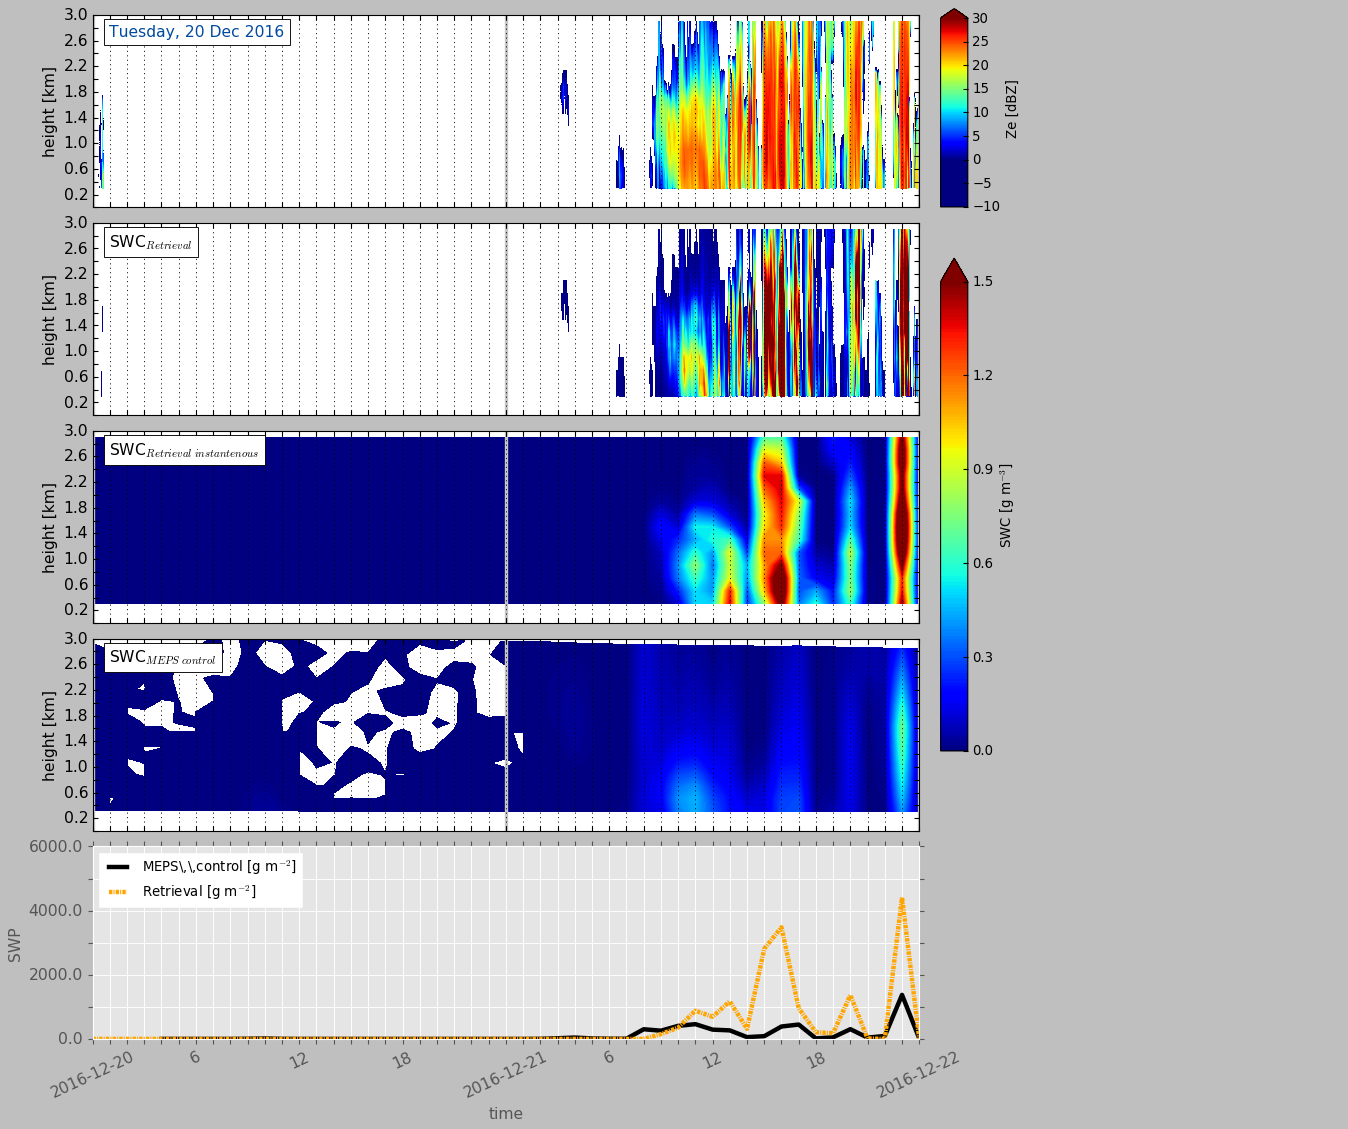

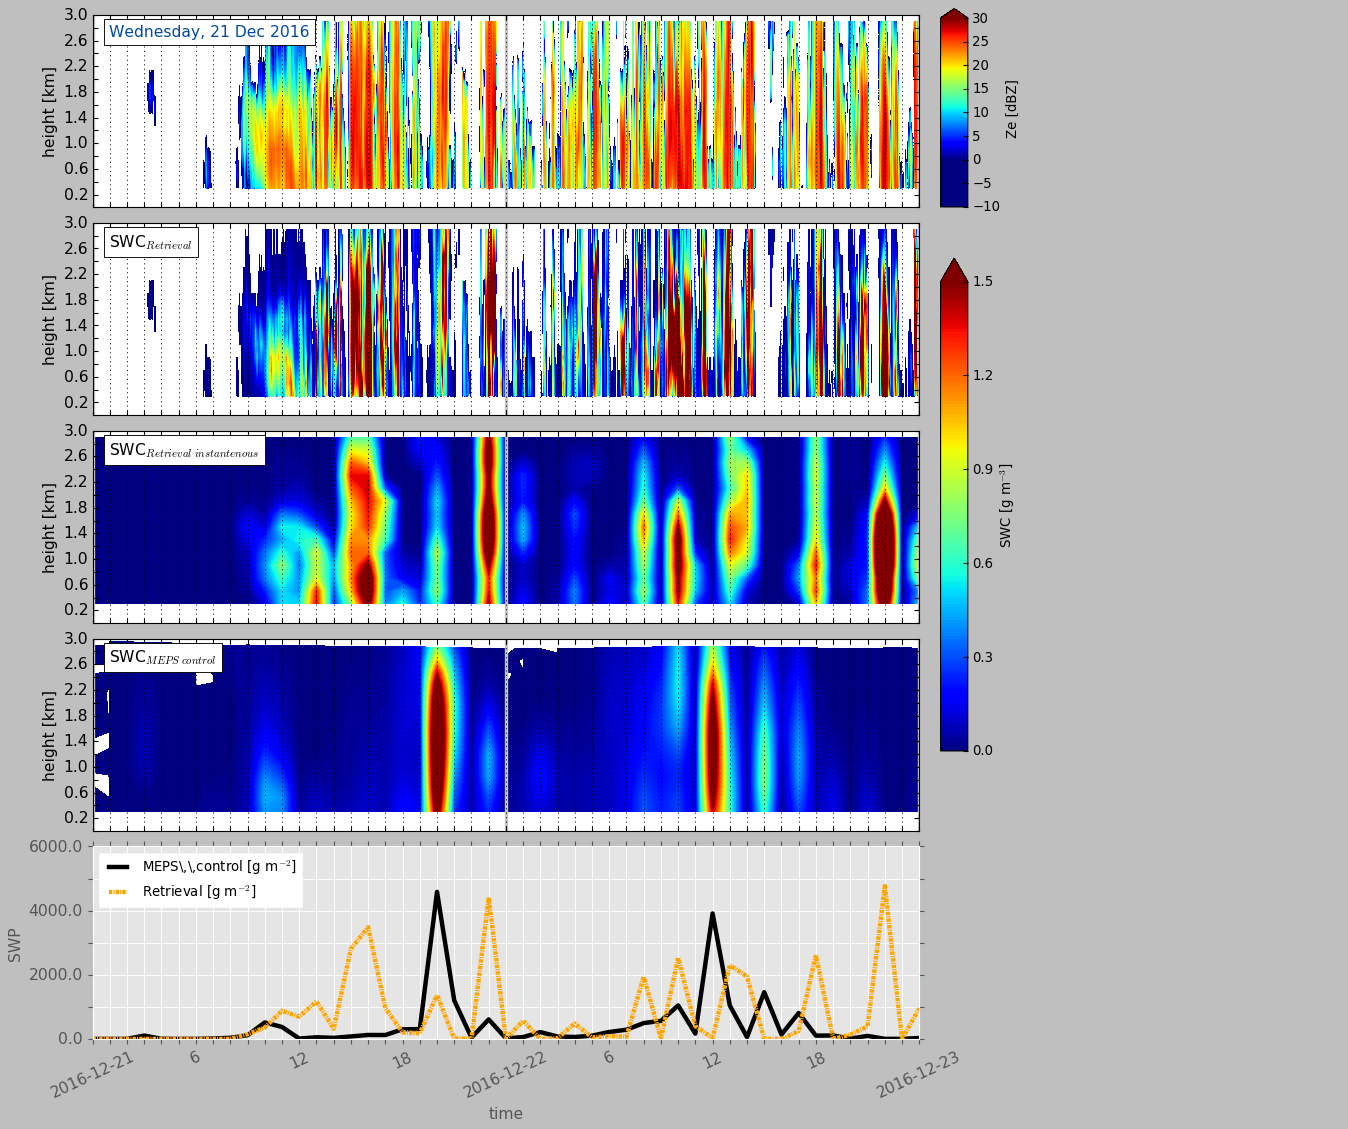

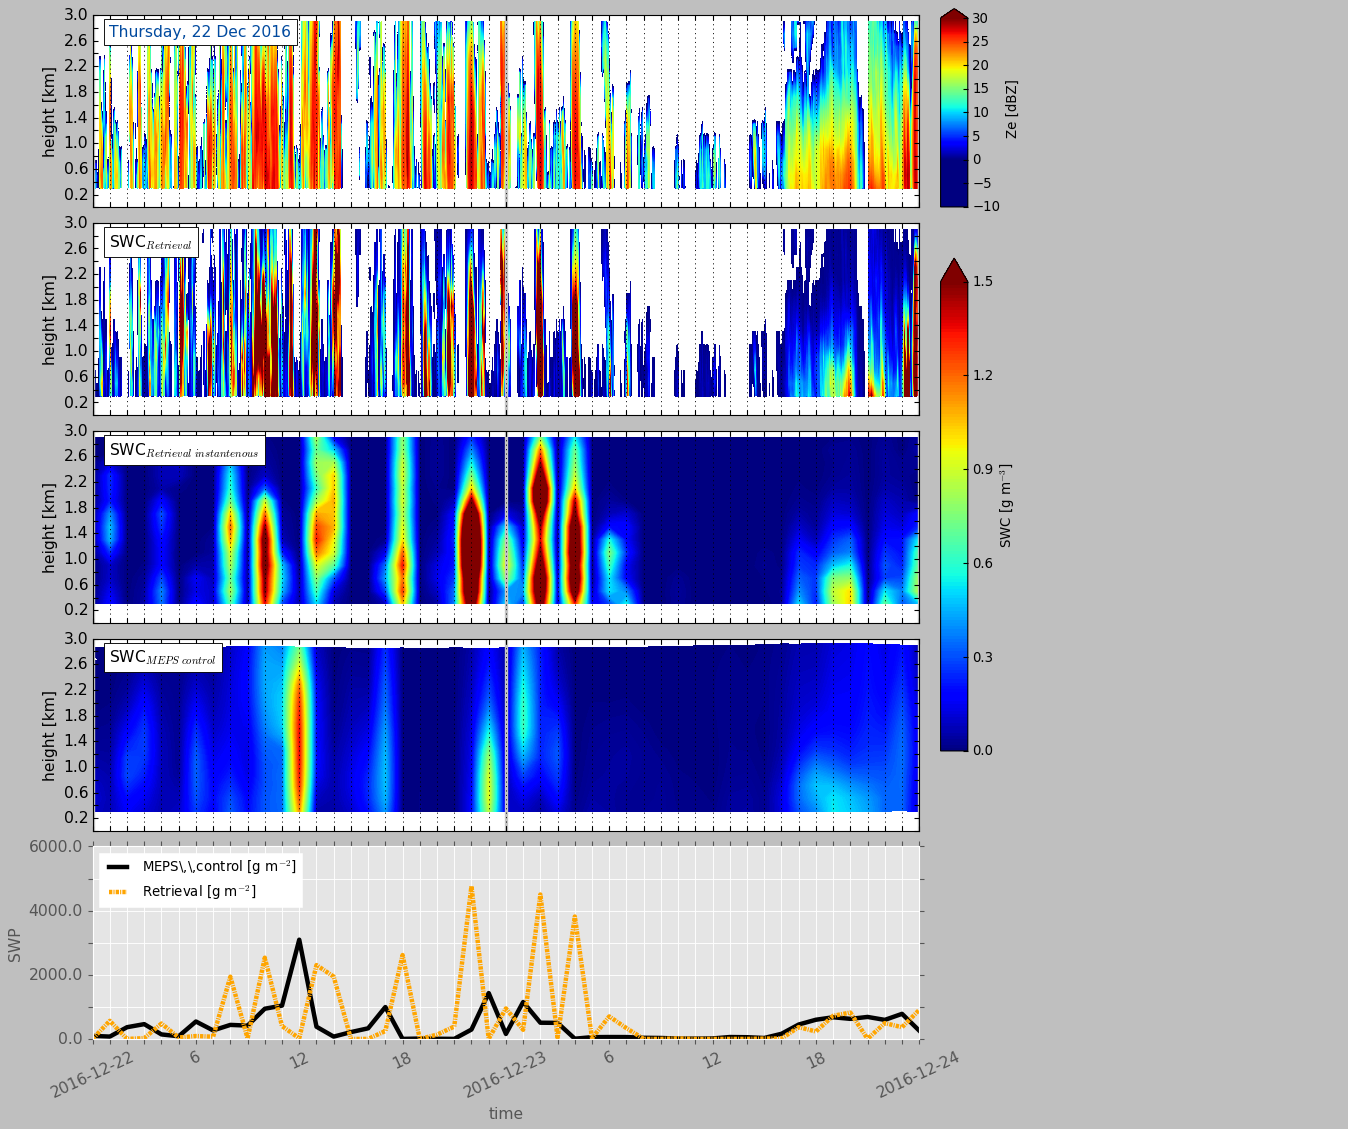

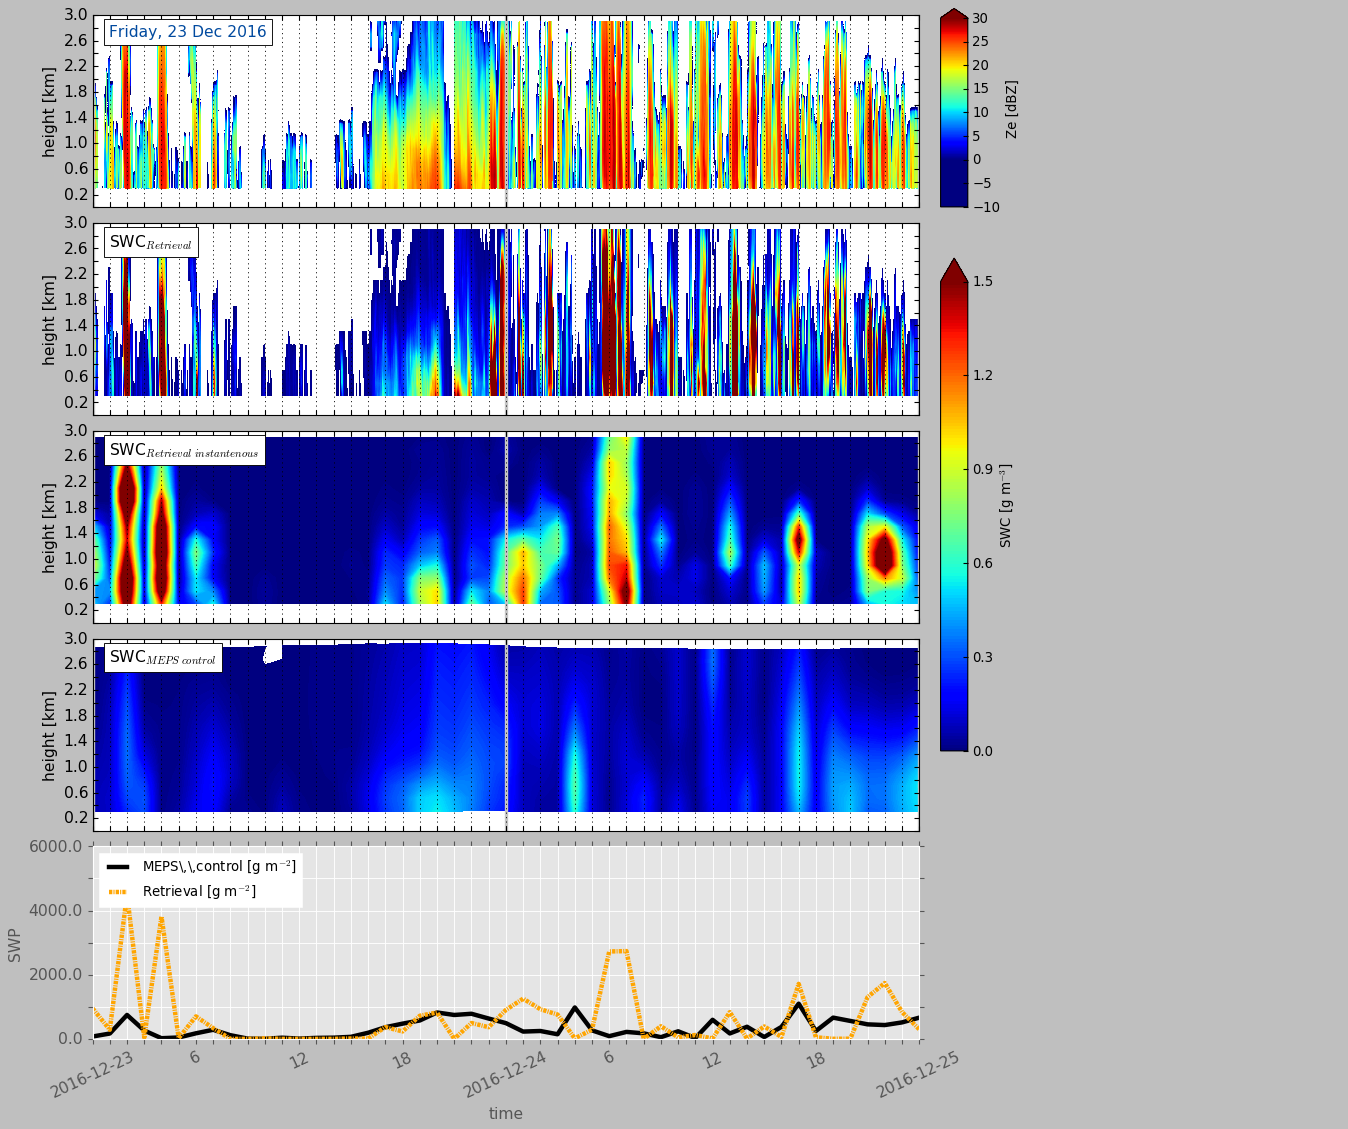

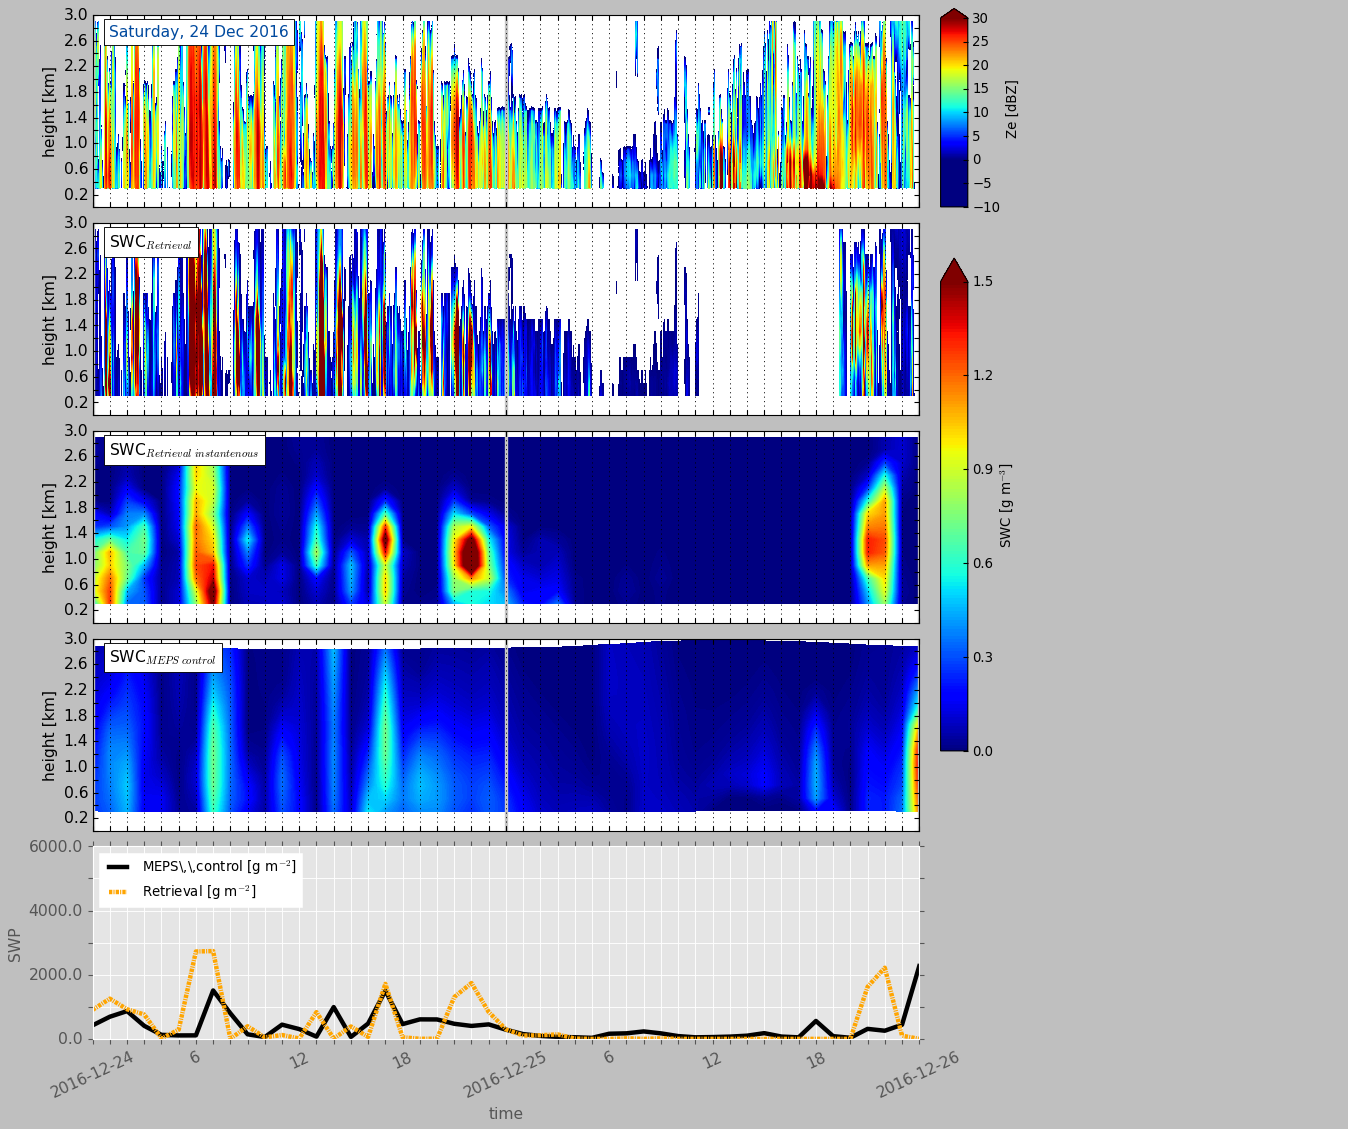

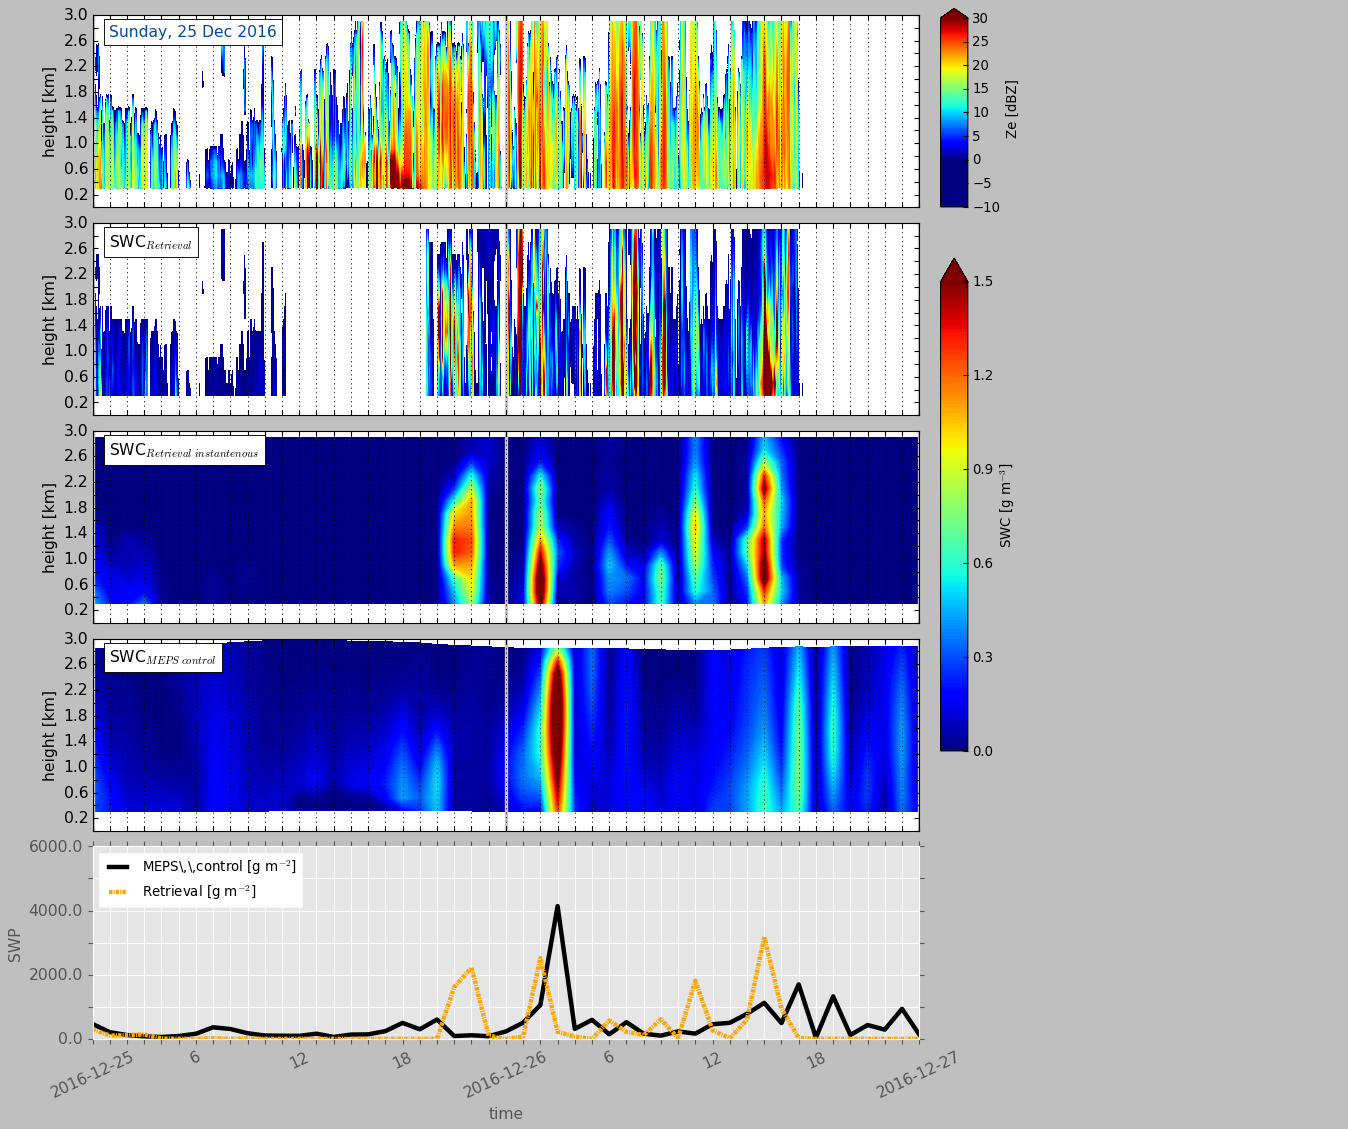

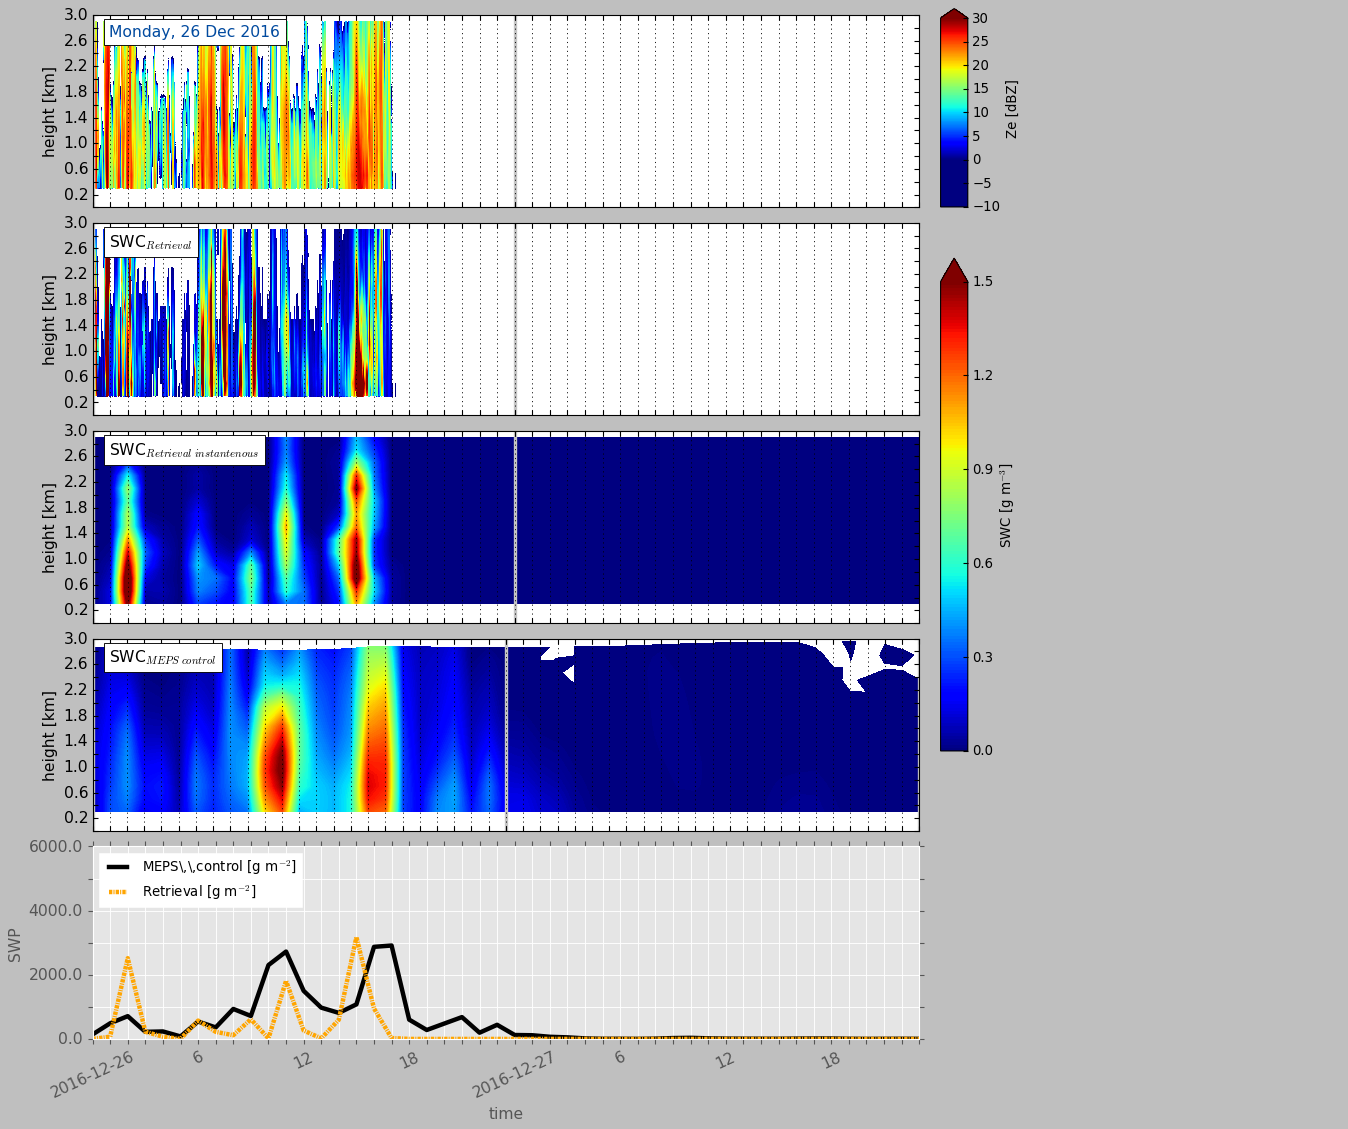

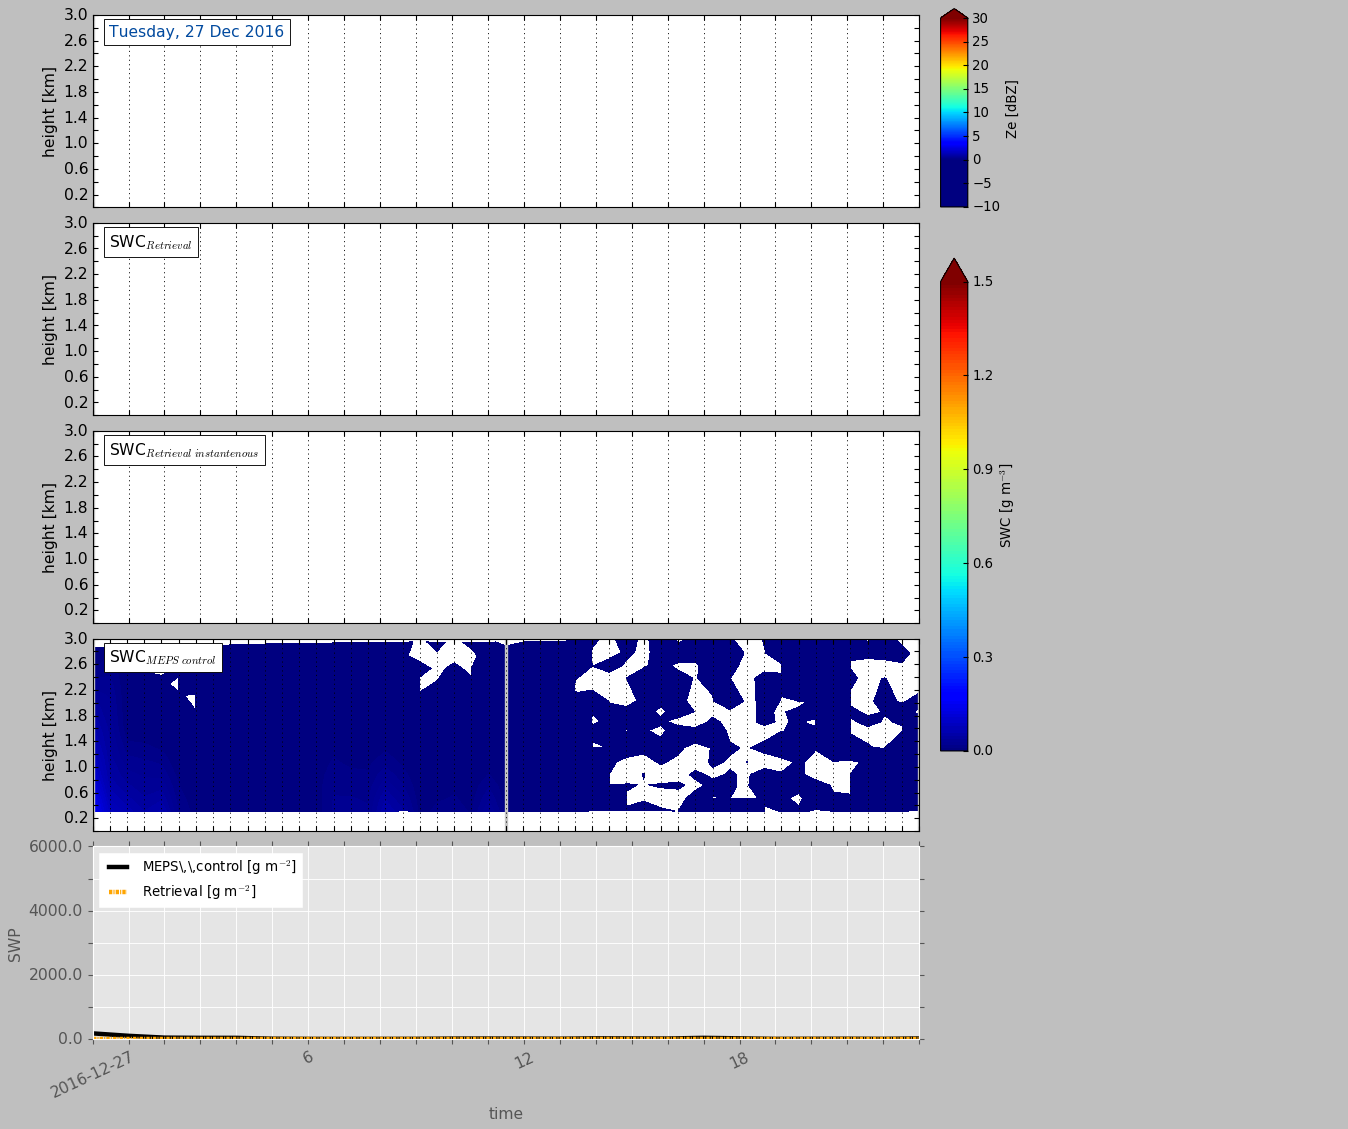

In [14]:
for day in t:
    Date = year+month+str(day)
    
    xdays = ['%s-%s-%s' %(year,month,day), '', '','','','',
            6, '', '','','','',12, '', '','','','', 18, '', '','','','',
            '%s-%s-%s' %(year,month,day+1),  '', '','','','',
            6, '', '','','','', 12, '', '','','','', 18, '', '','','','',
            '%s-%s-%s' %(year,month,day+2)]

    calday, calmon = cd.get_dayname(year, month, day)

    ### reflectivity and SWC minutely retrieval ####

    plt_SWC_retrieval(time_MRR[Date],height_MRR[Date],Ze_48[Date][:,:2*25*60],SWC_48[Date][:,:2*25*60], 
                      SWC_inst[Date][:,:2*25], SWP_inst[Date][:49],
                      time_MEPS[Date][:49,:], height_MEPS[Date][:49,:],SWC_MEPS[Date][:49,:],SWP_MEPS[Date][:49])

    if savefig ==1:
        fig_name = Date+'.'+form
        cF.createFolder('%s/SWC_MEPS_control_48/' %figdir)
        plt.savefig('%s/SWC_MEPS_control_48/%s' %(figdir,fig_name), format = form, bbox_inches ='tight')
        print('saved: %s/SWC_MEPS_control_48/%s' %(figdir,fig_name))
    else:
        plt.show()
    plt.close()

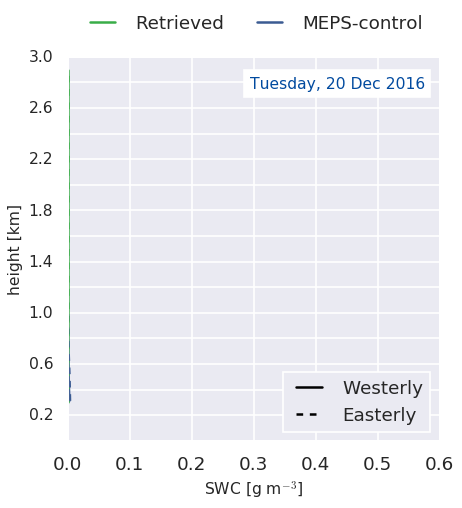

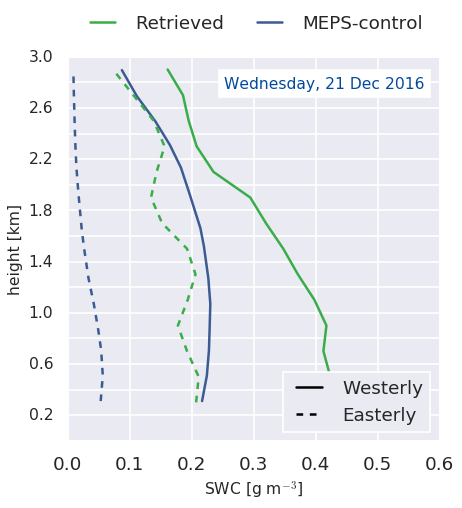

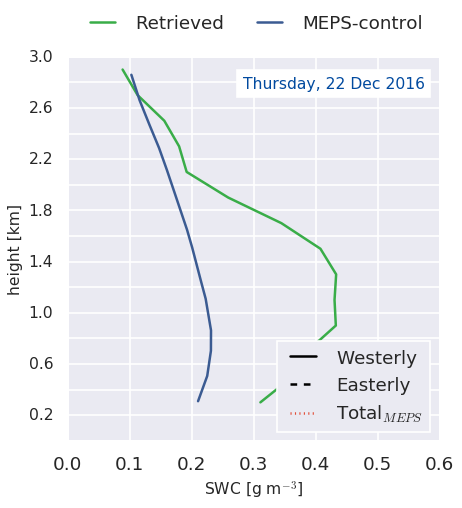

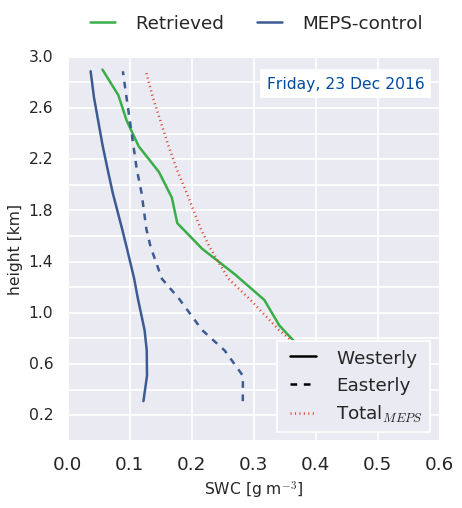

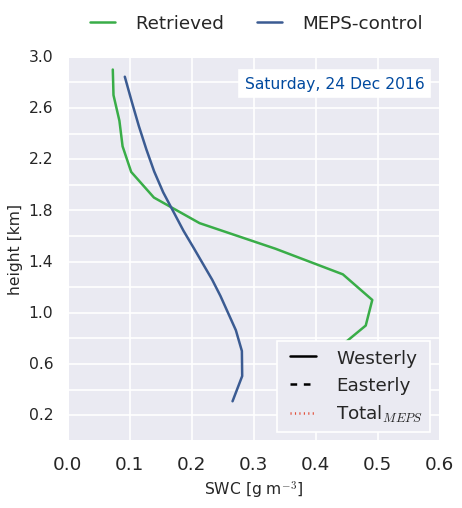

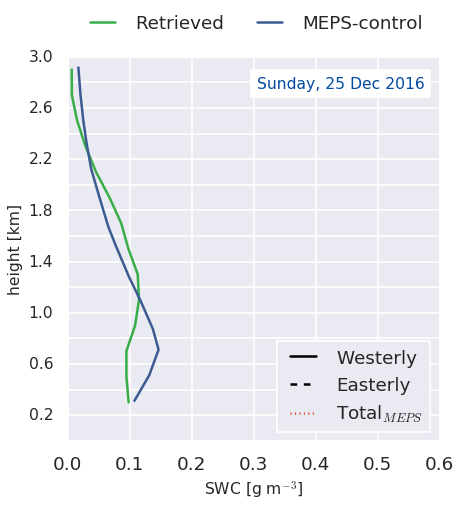

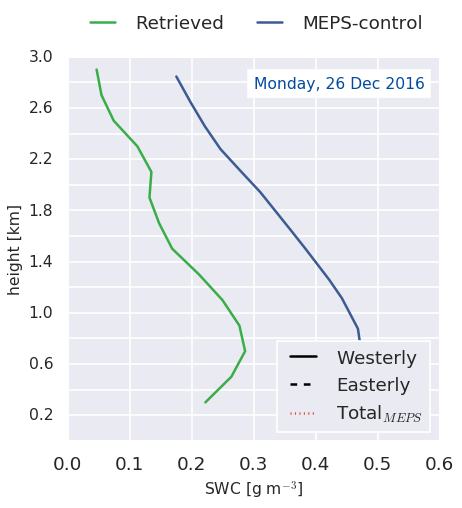

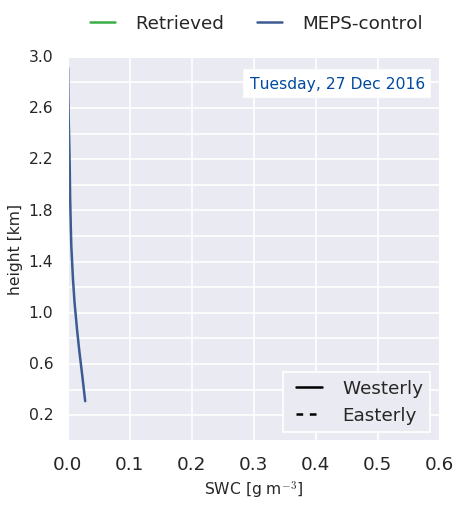

In [15]:
plt.rcParams.update({'font.size': 12})
seaborn.set_style("darkgrid")
seaborn.set_context("talk")


for day in t:
    Date = year+month+str(day)

    calday, calmon = cd.get_dayname(year, month, day)
    # Two subplots, unpack the axes array immediately
    f, axs = plt.subplots(1, 1, sharey=True)
    f.set_figheight(6)
    f.set_figwidth(6)
    f.subplots_adjust(hspace=.35, wspace=.15)


    l1, = axs.plot(SWC_24_west[Date][:], height_MRR[Date], color=seaborn.xkcd_rgb["medium green"])
    axs.plot(SWC_24_west_meps[Date][:], np.mean(height_MEPS[Date][:25,:], axis=0), color=seaborn.xkcd_rgb["denim blue"])
    
    l2, = axs.plot(SWC_24_east[Date][:], height_MRR[Date], color=seaborn.xkcd_rgb["medium green"], linestyle = '--')
    axs.plot(SWC_24_east_meps[Date][:], np.mean(height_MEPS[Date][:25,:], axis=0), color=seaborn.xkcd_rgb["denim blue"], linestyle = '--')
    
    legend1 = axs.legend([ 'Retrieved', 'MEPS-control',], ncol=3,
                         bbox_to_anchor=(0,1.02,1,0.2), loc='lower left', mode='expand',fancybox=True, facecolor ='white',
                         )
    
    if len(eklima_easterly_idx[Date][:]) == 0 or len(eklima_westerly_idx[Date][:])== 0:
        l3, = axs.plot(SWC_24_west_meps[Date][:]+SWC_24_east_meps[Date][:], np.mean(height_MEPS[Date][:25,:], axis=0), linestyle =':')
        legend2 = axs.legend([l1,l2,l3], ['Westerly', 'Easterly','Total$_{MEPS}$'],loc='lower right')
    else:
        legend2 = axs.legend([l1,l2], ['Westerly', 'Easterly'],loc='lower right')
    legend2.legendHandles[0].set_color('k')
    legend2.legendHandles[1].set_color('k')
    axs.add_artist(legend1)

    axs.set_xlim([0,0.6])
#    axs.set_xticklabels([0,0.2,0.4,0.6,0.8,1.,1.2,1.4,1.6], fontsize = im.tick_fs)
    axs.set_xlabel('SWC [g m$^{-3}$]',fontsize=im.label_fs)

    im.labels_y(axs,im.yticks1,im.yl1,'height [km]')

    axs.text(0.96,0.95, '%s, %s %s %s' %(calday, day, calmon, year),
                verticalalignment ='top', horizontalalignment='right',
                 transform = axs.transAxes,
                 color = im.date_blue, fontsize = im.fontsize+2,
                 bbox={'facecolor':'white','alpha':1.,'pad':5})
    
    if savefig ==1:
        fig_name = Date+'.'+form
        cF.createFolder('%s/vert_prof_SWC_MEPS_control_24/' %figdir)
        plt.savefig('%s/vert_prof_SWC_MEPS_control_24/%s' %(figdir,fig_name), format = form, bbox_inches ='tight')
        print('saved: %s/vert_prof_SWC_MEPS_control_24/%s' %(figdir,fig_name))
    else:
        plt.show()
    plt.close()

In [139]:
SWP_24_total_diff = dict()
SWP_24_west_diff = dict()
SWP_24_east_diff = dict()

for day in t:
        Date = year+month+str(day)
#    if len(eklima_easterly_idx[Date][:]) == 0 :
 #       SWP_24_total_diff[Date] = SWP_24_west_diff[Date] =  (integrate.simps(SWC_24_west_meps[Date][:], np.mean(height_MEPS[Date][:25,:], axis=0), axis = 0) - \
  #                             integrate.simps(SWC_24_west[Date][:], height_MRR[Date], axis = 0) )/integrate.simps(SWC_24_west[Date][:], height_MRR[Date], axis = 0) *100
   #     SWP_24_west_diff[Date] = (integrate.simps(SWC_24_west_meps[Date][:], np.mean(height_MEPS[Date][:25,:], axis=0), axis = 0) - \
    #                           integrate.simps(SWC_24_west[Date][:], height_MRR[Date], axis = 0) )/integrate.simps(SWC_24_west[Date][:], height_MRR[Date], axis = 0) *100
     #   SWP_24_east_diff[Date] = np.nan
#    elif len(eklima_westerly_idx[Date][:])== 0:
 #       SWP_24_total_diff[Date] =  (integrate.simps(SWC_24_east_meps[Date][:], np.mean(height_MEPS[Date][:25,:], axis=0), axis = 0) - \
  #                             integrate.simps(SWC_24_east[Date][:], height_MRR[Date], axis = 0) )/integrate.simps(SWC_24_east[Date][:], height_MRR[Date], axis = 0) *100
   #     SWP_24_west_diff[Date] = np.nan
    #    SWP_24_east_diff[Date] =  (integrate.simps(SWC_24_east_meps[Date][:], np.mean(height_MEPS[Date][:25,:], axis=0), axis = 0) - \
     #                          integrate.simps(SWC_24_east[Date][:], height_MRR[Date], axis = 0) )/integrate.simps(SWC_24_east[Date][:], height_MRR[Date], axis = 0) *100
#    else:
        SWP_24_total_diff[Date] =  (integrate.simps(SWC_24_total_meps[Date][:], np.mean(height_MEPS[Date][:25,:], axis=0), axis = 0) - \
                                integrate.simps(SWC_24_total[Date][:], height_MRR[Date], axis = 0) )/integrate.simps(SWC_24_total[Date][:], height_MRR[Date], axis = 0) *100

        SWP_24_west_diff[Date] =  (integrate.simps(SWC_24_west_meps[Date][:], np.mean(height_MEPS[Date][:25,:], axis=0), axis = 0) - \
                               integrate.simps(SWC_24_west[Date][:], height_MRR[Date], axis = 0) )/integrate.simps(SWC_24_west[Date][:], height_MRR[Date], axis = 0) *100

        SWP_24_east_diff[Date] =  (integrate.simps(SWC_24_east_meps[Date][:], np.mean(height_MEPS[Date][:25,:], axis=0), axis = 0) - \
                               integrate.simps(SWC_24_east[Date][:], height_MRR[Date], axis = 0) )/integrate.simps(SWC_24_east[Date][:], height_MRR[Date], axis = 0) *100

In [135]:
Date

'20161223'

In [138]:
(integrate.simps(SWC_24_east_meps[Date][:], np.mean(height_MEPS[Date][:25,:], axis=0), axis = 0) - 0)

407.4534320532221

In [140]:
SWP_urd_total = []
for v in SWP_24_total_diff.values():
    SWP_urd_total.append(v)

SWP_urd_west = []
for v in SWP_24_west_diff.values():
    print(v)
    SWP_urd_west.append(v)

SWP_urd_east = []
for v in SWP_24_east_diff.values():
#    print(v)
    SWP_urd_east.append(v)

inf
-38.674069889820615
-39.41758611499575
-60.97776756790447
-29.025417342566247
7.47416947747612
91.11051962879279
nan


In [141]:
SWP_urd_total

[inf,
 -87.9573541029487,
 -39.41758611499575,
 39.56305012722633,
 -29.025417342566247,
 7.47416947747612,
 91.11051962879279,
 nan]

In [142]:
SWP_urd_west

[inf,
 -38.674069889820615,
 -39.41758611499575,
 -60.97776756790447,
 -29.025417342566247,
 7.47416947747612,
 91.11051962879279,
 nan]

In [143]:
SWP_urd_east

[inf, -82.49600407556204, nan, nan, nan, nan, nan, nan]

In [144]:
np.mean(SWP_urd_total[1:7])

-3.0421030545025736

In [145]:
np.nanmean(SWP_urd_west[1:7])

-11.585025301503029

In [146]:
np.nanmean(SWP_urd_east[1:7])

-82.49600407556204